In [1]:
# What platform will the game be most popular on? 
# strategy: one hot encoding platform and genre, and use them as features to predict user_score
# the model takes one platform and multiple genres as input and chooses the platform with the highest user_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/games_of_all_time.csv')
data.head()

,game_name,meta_score,user_score,platform,description,url,developer,genre,type,rating
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,['nintendo-64'],"As a young boy, Link is tricked by Ganondorf, ...",https://www.metacritic.com/game/nintendo-64/th...,Nintendo,"['Action Adventure', 'Fantasy']",singleplayer,E
1,Super Mario Galaxy,97.0,91.0,['wii'],[Metacritic's 2007 Wii Game of the Year] The u...,https://www.metacritic.com/game/wii/super-mari...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E
2,Super Mario Galaxy 2,97.0,91.0,['wii'],"Super Mario Galaxy 2, the sequel to the galaxy...",https://www.metacritic.com/game/wii/super-mari...,Nintendo EAD Tokyo,"['Action', 'Platformer', '3D']",singleplayer,E
3,Metroid Prime,97.0,89.0,['gamecube'],Samus returns in a new mission to unravel the ...,https://www.metacritic.com/game/gamecube/metro...,Retro Studios,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",singleplayer,T
4,Super Mario Odyssey,97.0,89.0,['switch'],New Evolution of Mario Sandbox-Style Gameplay....,https://www.metacritic.com/game/switch/super-m...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E10+


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8831 entries, 0 to 8830
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_name    8831 non-null   object 
 1   meta_score   8831 non-null   float64
 2   user_score   8831 non-null   float64
 3   platform     8831 non-null   object 
 4   description  8831 non-null   object 
 5   url          8831 non-null   object 
 6   developer    8821 non-null   object 
 7   genre        8827 non-null   object 
 8   type         6727 non-null   object 
 9   rating       7691 non-null   object 
dtypes: float64(2), object(8)
memory usage: 690.0+ KB


In [3]:
data.isnull().sum()

game_name         0
meta_score        0
user_score        0
platform          0
description       0
url               0
developer        10
genre             4
type           2104
rating         1140
dtype: int64

In [4]:
df = data[['user_score', 'meta_score', 'platform', 'genre','type', 'rating']]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5936 entries, 0 to 8830
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_score  5936 non-null   float64
 1   meta_score  5936 non-null   float64
 2   platform    5936 non-null   object 
 3   genre       5936 non-null   object 
 4   type        5936 non-null   object 
 5   rating      5936 non-null   object 
dtypes: float64(2), object(4)
memory usage: 324.6+ KB


<AxesSubplot:xlabel='type', ylabel='count'>

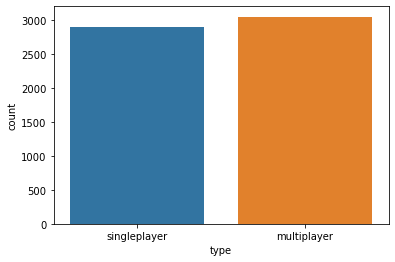

In [5]:
sns.countplot(x='type',data=df)

<AxesSubplot:xlabel='rating', ylabel='count'>

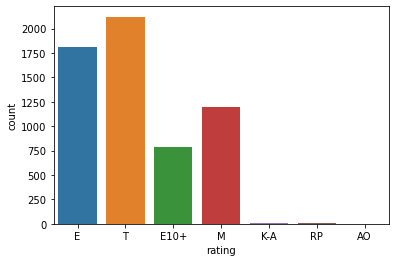

In [6]:
sns.countplot(x='rating',data=df)

In [7]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
p = df['platform'].map(ast.literal_eval)
g = df['genre'].map(ast.literal_eval)
mlb = MultiLabelBinarizer()

p_mlb = pd.DataFrame(mlb.fit_transform(p), columns=mlb.classes_, index=df.index)
g_mlb = pd.DataFrame(mlb.fit_transform(g), columns=mlb.classes_, index=df.index)
p_mlb = p_mlb.add_prefix('platform_')
g_mlb = g_mlb.add_prefix('genre_')
print(p_mlb)
print(g_mlb)

      platform_3ds  platform_dreamcast  platform_ds  \
0                0                   0            0   
1                0                   0            0   
2                0                   0            0   
3                0                   0            0   
4                0                   0            0   
...            ...                 ...          ...   
8825             0                   0            0   
8826             0                   0            0   
8827             0                   0            0   
8828             0                   0            0   
8830             0                   0            0   

      platform_game-boy-advance  platform_gamecube  platform_nintendo-64  \
0                             0                  0                     1   
1                             0                  0                     0   
2                             0                  0                     0   
3                             0    

In [9]:
df = df.drop('platform', axis=1)
df = df.drop('genre', axis=1)
df = pd.concat([df, p_mlb, g_mlb], 1)
df

,user_score,meta_score,type,rating,platform_3ds,platform_dreamcast,platform_ds,platform_game-boy-advance,platform_gamecube,platform_nintendo-64,...,genre_Virtual,genre_Virtual Life,genre_Visual Novel,genre_Volleyball,genre_WWI,genre_WWII,genre_Wakeboarding,genre_Wargame,genre_Western-Style,genre_Wrestling
0,91.0,99.0,singleplayer,E,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,91.0,97.0,singleplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,91.0,97.0,singleplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89.0,97.0,singleplayer,T,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,89.0,97.0,singleplayer,E10+,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,83.0,85.0,singleplayer,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8826,80.5,74.0,singleplayer,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8827,76.0,69.0,singleplayer,E10+,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8828,73.0,70.0,multiplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df['type']

0       singleplayer
1       singleplayer
2       singleplayer
3       singleplayer
4       singleplayer
            ...     
8825    singleplayer
8826    singleplayer
8827    singleplayer
8828     multiplayer
8830    singleplayer
Name: type, Length: 5936, dtype: object

In [11]:
df = pd.get_dummies(df, columns=['type'],drop_first=True)
df=pd.get_dummies(df, columns=['rating'])
df

,user_score,meta_score,platform_3ds,platform_dreamcast,platform_ds,platform_game-boy-advance,platform_gamecube,platform_nintendo-64,platform_pc,platform_playstation,...,genre_Western-Style,genre_Wrestling,type_singleplayer,rating_AO,rating_E,rating_E10+,rating_K-A,rating_M,rating_RP,rating_T
0,91.0,99.0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,91.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,91.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,89.0,97.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,89.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,83.0,85.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8826,80.5,74.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8827,76.0,69.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
8828,73.0,70.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(['user_score', 'meta_score'],axis=1).values
y = df['user_score'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [20]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [21]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,
          epochs=400)

Epoch 1/400
38/38 [==============================] - 0s 4ms/step - loss: 5180.7705 - val_loss: 5130.7534
Epoch 2/400
38/38 [==============================] - 0s 2ms/step - loss: 4896.3794 - val_loss: 4426.7627
Epoch 3/400
38/38 [==============================] - 0s 1ms/step - loss: 3218.5803 - val_loss: 1428.9669
Epoch 4/400
38/38 [==============================] - 0s 1ms/step - loss: 569.3845 - val_loss: 334.2229
Epoch 5/400
38/38 [==============================] - 0s 1ms/step - loss: 301.0746 - val_loss: 276.3706
Epoch 6/400
38/38 [==============================] - 0s 1ms/step - loss: 262.4561 - val_loss: 247.3945
Epoch 7/400
38/38 [==============================] - 0s 1ms/step - loss: 239.4097 - val_loss: 226.0449
Epoch 8/400
38/38 [==============================] - 0s 1ms/step - loss: 222.4729 - val_loss: 211.7156
Epoch 9/400
38/38 [==============================] - 0s 1ms/step - loss: 210.4578 - val_loss: 201.8818
Epoch 10/400
38/38 [==============================] - 0s 1ms/step -

Epoch 80/400
38/38 [==============================] - 0s 1ms/step - loss: 133.7846 - val_loss: 154.1015
Epoch 81/400
38/38 [==============================] - 0s 1ms/step - loss: 133.4624 - val_loss: 153.9390
Epoch 82/400
38/38 [==============================] - 0s 1ms/step - loss: 133.1043 - val_loss: 155.7650
Epoch 83/400
38/38 [==============================] - 0s 1ms/step - loss: 133.8495 - val_loss: 154.1514
Epoch 84/400
38/38 [==============================] - 0s 1ms/step - loss: 132.9554 - val_loss: 154.8020
Epoch 85/400
38/38 [==============================] - 0s 1ms/step - loss: 133.2293 - val_loss: 153.3140
Epoch 86/400
38/38 [==============================] - 0s 1ms/step - loss: 133.2350 - val_loss: 154.3510
Epoch 87/400
38/38 [==============================] - 0s 1ms/step - loss: 132.5814 - val_loss: 154.5760
Epoch 88/400
38/38 [==============================] - 0s 1ms/step - loss: 132.7084 - val_loss: 154.0504
Epoch 89/400
38/38 [==============================] - 0s 1ms/ste

38/38 [==============================] - 0s 1ms/step - loss: 127.5787 - val_loss: 156.8569
Epoch 159/400
38/38 [==============================] - 0s 2ms/step - loss: 127.4309 - val_loss: 158.3167
Epoch 160/400
38/38 [==============================] - 0s 1ms/step - loss: 126.8826 - val_loss: 157.1106
Epoch 161/400
38/38 [==============================] - 0s 1ms/step - loss: 127.9074 - val_loss: 157.2888
Epoch 162/400
38/38 [==============================] - 0s 1ms/step - loss: 127.1053 - val_loss: 157.1956
Epoch 163/400
38/38 [==============================] - 0s 1ms/step - loss: 127.2886 - val_loss: 156.9308
Epoch 164/400
38/38 [==============================] - 0s 1ms/step - loss: 126.9733 - val_loss: 156.8198
Epoch 165/400
38/38 [==============================] - 0s 1ms/step - loss: 126.6225 - val_loss: 157.9124
Epoch 166/400
38/38 [==============================] - 0s 1ms/step - loss: 126.4106 - val_loss: 156.8680
Epoch 167/400
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 1ms/step - loss: 124.8694 - val_loss: 159.2782
Epoch 237/400
38/38 [==============================] - 0s 1ms/step - loss: 125.0299 - val_loss: 159.6243
Epoch 238/400
38/38 [==============================] - 0s 1ms/step - loss: 126.3588 - val_loss: 158.2050
Epoch 239/400
38/38 [==============================] - 0s 1ms/step - loss: 124.3435 - val_loss: 159.1685
Epoch 240/400
38/38 [==============================] - 0s 1ms/step - loss: 124.5211 - val_loss: 159.7505
Epoch 241/400
38/38 [==============================] - 0s 1ms/step - loss: 124.7103 - val_loss: 158.6701
Epoch 242/400
38/38 [==============================] - 0s 1ms/step - loss: 124.5932 - val_loss: 159.7821
Epoch 243/400
38/38 [==============================] - 0s 1ms/step - loss: 124.7889 - val_loss: 158.8012
Epoch 244/400
38/38 [==============================] - 0s 1ms/step - loss: 124.2128 - val_loss: 158.9570
Epoch 245/400
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 1ms/step - loss: 120.1840 - val_loss: 163.6867
Epoch 315/400
38/38 [==============================] - 0s 1ms/step - loss: 120.1029 - val_loss: 164.3622
Epoch 316/400
38/38 [==============================] - 0s 1ms/step - loss: 120.0644 - val_loss: 163.9132
Epoch 317/400
38/38 [==============================] - 0s 1ms/step - loss: 119.7449 - val_loss: 163.5571
Epoch 318/400
38/38 [==============================] - 0s 1ms/step - loss: 119.7036 - val_loss: 162.7684
Epoch 319/400
38/38 [==============================] - 0s 1ms/step - loss: 120.5622 - val_loss: 162.6128
Epoch 320/400
38/38 [==============================] - 0s 1ms/step - loss: 120.3888 - val_loss: 163.5051
Epoch 321/400
38/38 [==============================] - 0s 1ms/step - loss: 120.1057 - val_loss: 165.7965
Epoch 322/400
38/38 [==============================] - 0s 2ms/step - loss: 120.2840 - val_loss: 162.9640
Epoch 323/400
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 1ms/step - loss: 116.1585 - val_loss: 165.4962
Epoch 393/400
38/38 [==============================] - 0s 1ms/step - loss: 115.8739 - val_loss: 167.1580
Epoch 394/400
38/38 [==============================] - 0s 1ms/step - loss: 117.3814 - val_loss: 168.3908
Epoch 395/400
38/38 [==============================] - 0s 1ms/step - loss: 116.0507 - val_loss: 167.8517
Epoch 396/400
38/38 [==============================] - 0s 1ms/step - loss: 116.5628 - val_loss: 166.7883
Epoch 397/400
38/38 [==============================] - 0s 1ms/step - loss: 115.6730 - val_loss: 168.3107
Epoch 398/400
38/38 [==============================] - 0s 1ms/step - loss: 115.7700 - val_loss: 166.6093
Epoch 399/400
38/38 [==============================] - 0s 1ms/step - loss: 115.9977 - val_loss: 168.1454
Epoch 400/400
38/38 [==============================] - 0s 1ms/step - loss: 116.2290 - val_loss: 166.7170


In [22]:
from tensorflow.keras.models import load_model

In [23]:
model.save('evan_model.h5')  

In [24]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

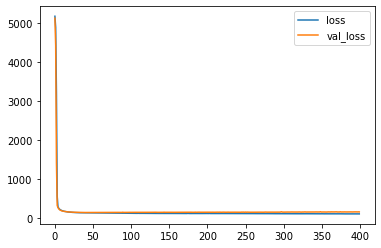

In [25]:
losses[['loss','val_loss']].plot()

In [62]:
X_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
predictions = model.predict(X_test)
predictions

array([[76.7651  ],
       [80.795296],
       [62.980988],
       ...,
       [65.56405 ],
       [71.09546 ],
       [69.338394]], dtype=float32)

In [28]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [29]:
mean_absolute_error(y_test,predictions)

9.858511570246534

In [30]:
np.sqrt(mean_squared_error(y_test,predictions))

12.911894308690032

In [31]:
explained_variance_score(y_test,predictions)

-0.008793527051736305

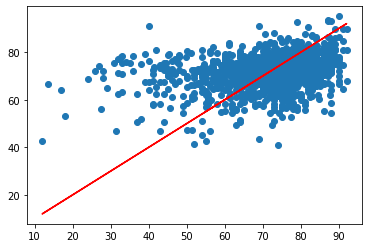

In [32]:
plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,'r')

In [33]:
p_shape = predictions.shape
p_shape

(1188, 1)

In [34]:
errors = y_test.reshape(p_shape[0], p_shape[1]) - predictions

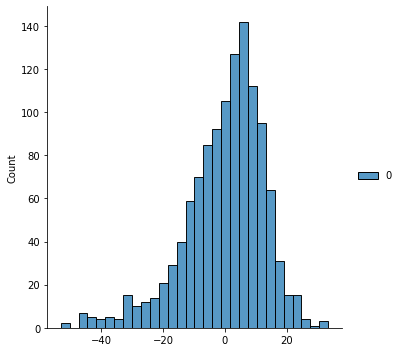

In [35]:
sns.displot(errors)

In [39]:
platform_col = [col for col in df if col.startswith('platform')]
platform_col

['platform_3ds',
 'platform_dreamcast',
 'platform_ds',
 'platform_game-boy-advance',
 'platform_gamecube',
 'platform_nintendo-64',
 'platform_pc',
 'platform_playstation',
 'platform_playstation-2',
 'platform_playstation-3',
 'platform_playstation-4',
 'platform_playstation-5',
 'platform_playstation-vita',
 'platform_psp',
 'platform_stadia',
 'platform_switch',
 'platform_wii',
 'platform_wii-u',
 'platform_xbox',
 'platform_xbox-360',
 'platform_xbox-one',
 'platform_xbox-series-x']

In [40]:
genre_col = [col for col in df if col.startswith('genre')]
genre_col

['genre_2D',
 'genre_3D',
 'genre_4X',
 'genre_Action',
 'genre_Action Adventure',
 'genre_Action RPG',
 'genre_Adventure',
 'genre_Alternative',
 'genre_Application',
 'genre_Arcade',
 'genre_Artillery',
 'genre_Athletics',
 'genre_Automobile',
 'genre_Baseball',
 'genre_Basketball',
 "genre_Beat-'Em-Up",
 'genre_Biking',
 'genre_Billiards',
 'genre_Board / Card Game',
 'genre_Board Games',
 'genre_Bowling',
 'genre_Boxing',
 'genre_Boxing / Martial Arts',
 'genre_Breeding/Constructing',
 'genre_Business / Tycoon',
 'genre_Car Combat',
 'genre_Card Battle',
 'genre_Career',
 'genre_City Building',
 'genre_Civilian',
 'genre_Combat',
 'genre_Command',
 'genre_Compilation',
 'genre_Console-style RPG',
 'genre_Cricket',
 'genre_Dancing',
 'genre_Defense',
 'genre_Demolition Derby',
 'genre_Drag',
 'genre_Driving',
 'genre_Edutainment',
 'genre_Exercise / Fitness',
 'genre_Fantasy',
 'genre_Fighting',
 'genre_First-Person',
 'genre_Fishing',
 'genre_Flight',
 'genre_Football',
 'genre_For

In [38]:
predictions

array([[76.7651  ],
       [80.795296],
       [62.980988],
       ...,
       [65.56405 ],
       [71.09546 ],
       [69.338394]], dtype=float32)

In [46]:
len(X[0])

196

In [75]:
def get_best_platform(genre, type, rating):
    most_popular_platform = ''
    user_score = 0
    test = np.zeros(196)
    test[df.columns.get_loc(type) - 2] = 1
    test[df.columns.get_loc(rating) - 2] = 1
    for g in genre:
        # remove first 2 column
        test[df.columns.get_loc(g) - 2] = 1
    
    print(test.shape)
    for p in platform_col:
        test[df.columns.get_loc(p) - 2] = 1
        
        predict_score = model.predict(test.reshape(1,196))
        if (user_score < predict_score):
            user_score = predict_score
            most_popular_platform = p
        
        test[df.columns.get_loc(p) - 2] = 0
     
    return most_popular_platform
    

In [76]:
X[0].shape

(196,)

In [77]:
predict_platform = get_best_platform(['genre_3D','genre_Action RPG','genre_MOBA'], 'type_singleplayer', 'rating_E')
predict_platform

(196,)


'platform_stadia'